# Load files

In [1]:
import numpy as np
import glob
import os
%pylab inline --no-import-all
plt.rc('font', family='serif', serif='Times', size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure', titlesize=25)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['axes.linewidth'] = 2.
from astropy.io import fits

import logging as log
from crispy.tools.initLogger import getLogger
log = getLogger('main')
from crispy.tools.image import Image
os.chdir('/Users/mrizzo/IFS/crispy/crispy/WFIRST/')
from params import Params
import scipy as sp

par = Params()
par.hdr
cmap = 'inferno'  # 'gray_r'

Populating the interactive namespace from numpy and matplotlib


In [32]:
from crispy.tools.reduction import _add_row

lensX = 10
lensY = 10

from crispy.tools.locate_psflets import PSFLets
from crispy.tools.reduction import get_cutout
polychromeR = fits.open(par.wavecalDir + 'polychromeR%d.fits.gz' % (par.R))
psflets = polychromeR[0].data
n_add = 1
psflets = _add_row(psflets, n=n_add, dtype=np.float64)
psflets[-n_add:] = 0
psflets[-1, 4:-4, 4:-4] = 1

psftool = PSFLets()
lamlist = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 0]
allcoef = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 1:]

# lam in nm
psftool.geninterparray(lamlist, allcoef)

xlist = []
ylist = []
for lam in lamlist:
    _x, _y = psftool.return_locations(lam, allcoef, lensX, lensY)
    xlist += [_x]
    ylist += [_y]

im = Image(filename=par.wavecalDir + 'polychromeR%dstack.fits.gz' % (par.R))
subim, psflet_subarr, [x0, x1, y0, y1] = get_cutout(im, xlist, ylist, psflets)

crispy - INFO - Read data from HDU 0 of ..//ReferenceFiles/wavecalR50_660/polychromeR50stack.fits.gz


In [33]:
for i in range(psflet_subarr.shape[0]-1):
    psflet_subarr[i] /= np.sum(psflet_subarr[i])

Nbins = len(psflet_subarr)
print Nbins

19


In [5]:
polychromeR1px = fits.open(
    par.prefix+'/wavecalR50_660_1pix/polychromeR%d.fits.gz' % (par.R))
psflets = polychromeR1px[0].data
psftool = PSFLets()
lamlist = np.loadtxt(par.prefix+'/wavecalR50_660_1pix/lamsol.dat')[:, 0]
allcoef = np.loadtxt(par.prefix+'/wavecalR50_660_1pix/lamsol.dat')[:, 1:]

# lam in nm
psftool.geninterparray(lamlist, allcoef)

xlist = []
ylist = []
for lam in lamlist:
    _x, _y = psftool.return_locations(lam, allcoef, lensX, lensY)
    xlist += [_x]
    ylist += [_y]

im = Image(filename=par.prefix +
           '/wavecalR50_660_1pix/polychromeR%dstack.fits.gz' % (par.R))
subim_1px, psflet_subarr_1px, [x0, x1, y0,
                               y1] = get_cutout(im, xlist, ylist, psflets)
for i in range(psflet_subarr_1px.shape[0]):
    psflet_subarr_1px[i] /= np.sum(psflet_subarr_1px[i])
Nbins1px = len(psflet_subarr_1px)
print Nbins, Nbins1px

crispy - INFO - Read data from HDU 0 of ..//ReferenceFiles/wavecalR50_660_1pix/polychromeR50stack.fits.gz
18 9


19
[  74.87067475  120.70295465   92.42098154  110.50719796   88.6213768
   87.67333282   81.47929672   99.32780597   90.16923282   98.33055468
   96.35018123   97.02262241   96.03468295   87.68070381  108.11633575
   86.56658908   99.69636262  100.68779943    2.17929003]


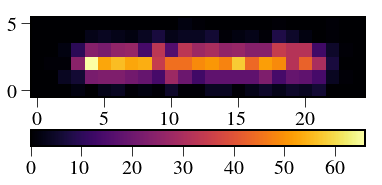

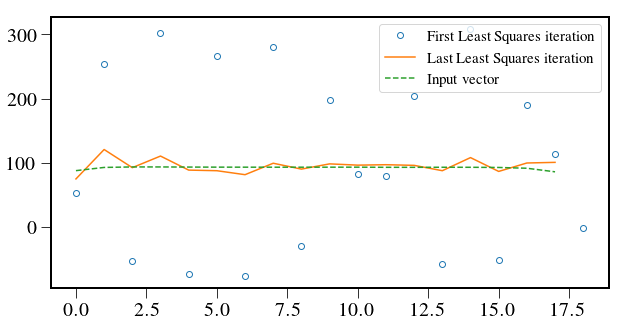

In [54]:
import scipy as sp
psflets_flat = np.reshape(psflet_subarr, (psflet_subarr.shape[0], -1))
A = psflets_flat.T
N = psflet_subarr.shape[0]
Niter = 5
print N
lstsq = np.zeros((N, Niter+1))
lstsq_notsmoothed = np.zeros((N, Niter+1))


pixnoise = 0
vect = np.ones(N)*100
vect[-1] = pixnoise
pimg = np.random.poisson(
    np.sum(psflet_subarr*vect[:, np.newaxis, np.newaxis], axis=0))
plt.imshow(pimg, cmap=cmap)
plt.colorbar(orientation='horizontal')


# img = pimg-pixnoise
img = pimg
sumpix = np.sum(img)
lstsq[:, 0] = np.ones(N)*sumpix/float(N)
lstsq[-1,0] = 0.
lstsq_notsmoothed[:, 0] = np.ones(N)*sumpix/float(N)
for i in range(Niter):
    prev = lstsq[:, i]
    variance = np.reshape(
        np.sum(psflet_subarr*prev[:, np.newaxis, np.newaxis], axis=0), -1)
#         np.sum(psflet_subarr*prev[:, np.newaxis, np.newaxis], axis=0)+pixnoise, -1)
    Ninv = np.diag(1./(variance+1e-10))
    Cinv = np.dot(A.T, np.dot(Ninv, A))
    C = np.linalg.inv(Cinv)
    Q = sp.linalg.sqrtm(Cinv)
    s = np.sum(Q, axis=0)
    R = Q/s[:, np.newaxis]
    x = np.reshape(img, -1)
    right = np.dot(A.T, np.dot(Ninv, x))
    f = np.dot(C, right)
    lstsq_notsmoothed[:, i+1] = f
    lstsq[:, i+1] = np.dot(R, f)
outvect = np.dot(R, vect)
plt.figure(figsize=(10, 5))
plt.plot(np.dot(np.linalg.inv(R),lstsq[:, 1]), linestyle='none', marker='o',
         markerfacecolor='none', label="First Least Squares iteration")
plt.plot(lstsq[:-1, -1], label="Last Least Squares iteration")
# plt.plot(lstsq_notsmoothed[:-1, -1],
#          label="Last Least Squares iteration, unsmoothed")
plt.plot(outvect[:-1], '--', label="Input vector")
plt.legend()
print lstsq[:, -1]

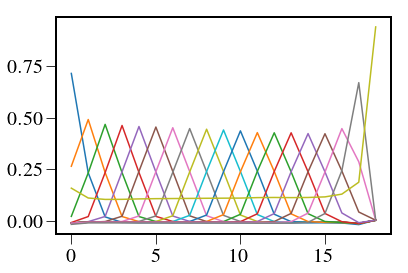

In [51]:
plt.plot(R)

9


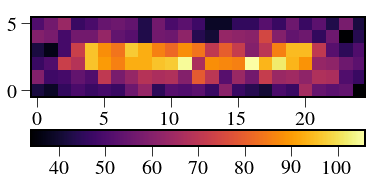

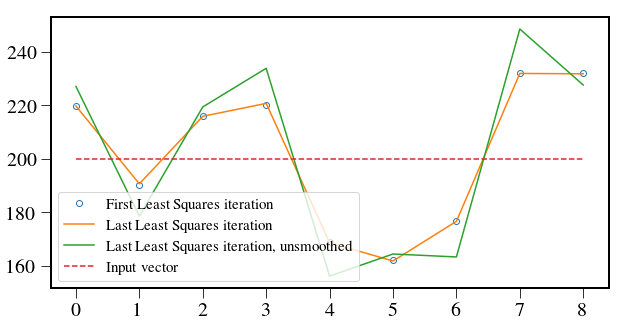

In [7]:
import scipy as sp
psflet_flat_1px = np.reshape(
    psflet_subarr_1px, (psflet_subarr_1px.shape[0], -1))
A1px = psflet_flat_1px.T
N1px = psflet_subarr_1px.shape[0]
Niter = 50
print N1px
lstsq1px = np.zeros((N1px, Niter+1))
lstsq_notsmoothed1px = np.zeros((N1px, Niter+1))


pixnoise = 50
vect = np.ones(N1px)*100*N/N1px
pimg = np.random.poisson(
    np.sum(psflet_subarr_1px*vect[:, np.newaxis, np.newaxis], axis=0)+pixnoise)
plt.imshow(pimg, cmap=cmap)
plt.colorbar(orientation='horizontal')


img = pimg-pixnoise
sumpix = np.sum(img)
lstsq1px[:, 0] = np.ones(N1px)*sumpix/float(N1px)/2
lstsq_notsmoothed1px[:, 0] = np.ones(N1px)*sumpix/float(N1px)/2
for i in range(Niter):
    prev = lstsq1px[:, i]
    variance = np.reshape(
        np.sum(psflet_subarr_1px*prev[:, np.newaxis, np.newaxis], axis=0)+pixnoise, -1)
    Ninv = np.diag(1./(variance+1e-10))
    Cinv = np.dot(A1px.T, np.dot(Ninv, A1px))
    C = np.linalg.inv(Cinv)
    Q = sp.linalg.sqrtm(Cinv)
    s = np.sum(Q, axis=0)
    R1px = Q/s[:, np.newaxis]
    x = np.reshape(img, -1)
    right = np.dot(A1px.T, np.dot(Ninv, x))
    f = np.dot(C, right)
    lstsq_notsmoothed1px[:, i+1] = f
    lstsq1px[:, i+1] = np.dot(R1px, f)
outvect1px = np.dot(R1px, vect)
plt.figure(figsize=(10, 5))
plt.plot(lstsq1px[:, 1], linestyle='none', marker='o',
         markerfacecolor='none', label="First Least Squares iteration")
plt.plot(lstsq1px[:, -1], label="Last Least Squares iteration")
plt.plot(lstsq_notsmoothed1px[:, -1],
         label="Last Least Squares iteration, unsmoothed")
plt.plot(outvect1px[:], '--', label="Input vector")
plt.legend()

0.896115974406
0.853353447798


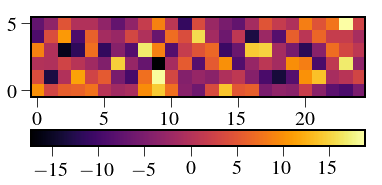

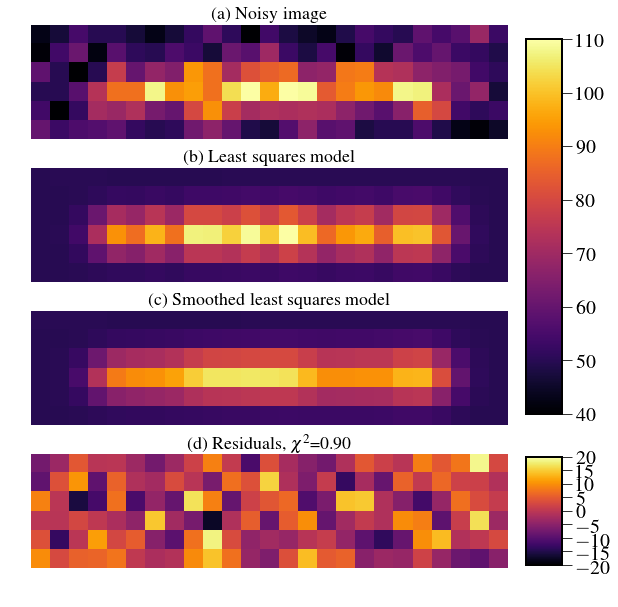

In [12]:
plt.figure()
final = lstsq[:, -1]
model = pixnoise+np.sum(psflet_subarr*final[:, np.newaxis, np.newaxis], axis=0)
model_notsmoothed = pixnoise + \
    np.sum(psflet_subarr*final[:, np.newaxis, np.newaxis], axis=0)
res = pimg-model
plt.imshow(res, cmap=cmap)
plt.colorbar(orientation='horizontal')

chi2 = np.sum(res**2/model)/np.prod(res.shape)
chi2_notsmoothed = np.sum((pimg)**2/model)/np.prod(res.shape)
print chi2

fig, axarr = plt.subplots(4, 1, figsize=(10, 10))
axarr[0].axis('off')
axarr[0].set_title('(a) Noisy image')
im = axarr[0].imshow(pimg, cmap=cmap, vmin=40, vmax=110)

axarr[2].imshow(model, cmap=cmap, vmin=40, vmax=110)
axarr[2].set_title('(c) Smoothed least squares model')
axarr[2].axis('off')
axarr[1].axis('off')
final = lstsq_notsmoothed[:, -1]
model_notsmoothed = pixnoise + \
    np.sum(psflet_subarr*final[:, np.newaxis, np.newaxis], axis=0)
chi2_notsmoothed = np.sum((pimg-model_notsmoothed) **
                          2/model_notsmoothed)/np.prod(res.shape)
print chi2_notsmoothed

axarr[1].imshow(model_notsmoothed, cmap=cmap, vmin=40, vmax=110)
axarr[1].set_title('(b) Least squares model')

axarr[3].axis('off')
axarr[3].set_title('(d) Residuals, $\chi^2$={:.2f}'.format(chi2))
im2 = axarr[3].imshow(res, cmap=cmap, vmin=-20, vmax=20)

fig.subplots_adjust(right=0.8, wspace=0.1, hspace=0.25)
cbar_ax = fig.add_axes([0.82, 0.34, 0.05, 0.52])
fig.colorbar(im, cax=cbar_ax)
cbar_ax = fig.add_axes([0.82, 0.13, 0.05, 0.15])
fig.colorbar(im2, cax=cbar_ax)

fig.savefig('/Users/mrizzo/Downloads/Microspectrum_Extraction.pdf',
            dpi=150, bbox_inches='tight')

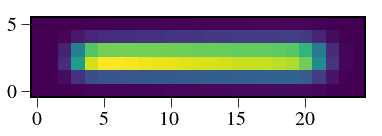

In [9]:
vect = np.ones(N)*100
plt.imshow(np.sum(psflet_subarr*vect[:, np.newaxis, np.newaxis], axis=0))

crispy - INFO - Reduced cube will have 18 wavelength bins


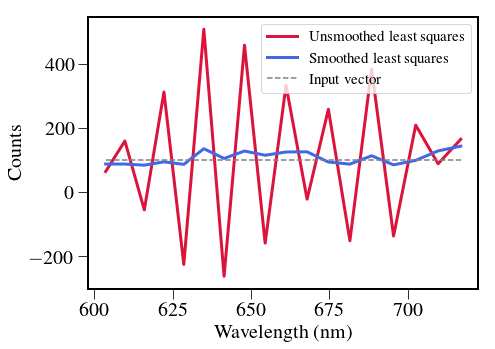

In [13]:
plt.figure(figsize=(7, 5))
from crispy.tools.reduction import calculateWaveList
lam_midpts, _ = calculateWaveList(par, method='lstsq')
# plt.plot(lstsq[:,1],linestyle='none',marker='o',markerfacecolor='none',label="First Least Squares iteration")
plt.plot(lam_midpts, lstsq_notsmoothed[:, -1],
         label="Unsmoothed least squares", color='crimson', lw=3)
plt.plot(lam_midpts, lstsq[:, -1],
         label="Smoothed least squares ", color='royalblue', lw=3)
plt.plot(lam_midpts, outvect[:], '--', label="Input vector", color='gray')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Counts')
plt.savefig('/Users/mrizzo/Downloads/Extracted_Microspectrum.pdf',
            dpi=150, bbox_inches='tight')

crispy - INFO - Reduced cube will have 18 wavelength bins
MSE= 0.0075718565006


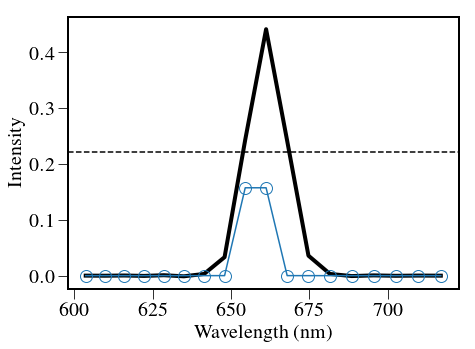

In [11]:
import pandas as pd
from crispy.tools.reduction import calculateWaveList
from scipy import signal
plt.figure(figsize=(7, 5))
pd.DataFrame(data=R)
lam_midpts, _ = calculateWaveList(par, method='lstsq')
plt.plot(lam_midpts, R[N/2, :], lw=4,
         label='Measured spectrograph resolution', color='k')
plt.plot(lam_midpts, 
         signal.gaussian(N, std=Nbins/11./2./2.35)*np.amax(R[N/2, :]), 
         label='Gaussian of FWHM=2', marker='o',
         markerfacecolor='none', markersize=12)
plt.axhline(y=np.amax(R[N/2, :])/2, color='k', linestyle='dashed')
# plt.text(610,0.23,"Half Maximum",fontsize=20)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
# plt.title('Instrument line function')
plt.savefig('/Users/mrizzo/Downloads/Instrument_Line_Function.pdf',
            dpi=150, bbox_inches='tight')
MSE = np.sum((R[N/2, :]-signal.gaussian(N, std=19./11./2./2.35)
              * np.amax(R[N/2, :]))**2)/len(R[N/2, :])
print "MSE=", MSE
np.savetxt('/Users/mrizzo/Downloads/Rmatrix%d.txt' % (N), R)
# plt.plot(R[2,:],linestyle='dotted')
# plt.plot(R[-3,:],linestyle='dotted')
# plt.axvline(x=10,color='red',linestyle='dashed')
# plt.axvline(x=8,color='red',linestyle='dashed')
# plt.legend()

crispy - INFO - Reduced cube will have 9 wavelength bins
crispy - INFO - Reduced cube will have 18 wavelength bins


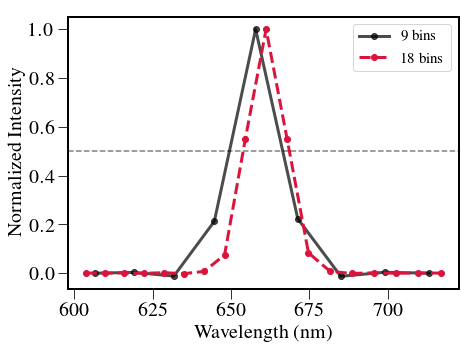

In [14]:
plt.figure(figsize=(7, 5))
lam_midpts, _ = calculateWaveList(par, method='lstsq', Nspec=Nbins1px+1)
# R11 = np.loadtxt('/Users/mrizzo/Downloads/Rmatrix11.txt')
plt.plot(lam_midpts, R1px[Nbins1px/2, :]/np.amax(R1px[Nbins1px/2, :]),
         lw=3, label='%d bins' % (Nbins1px), color='k', alpha=0.7, marker='o')
lam_midpts, _ = calculateWaveList(par, method='lstsq')
plt.plot(lam_midpts, R[Nbins/2, :]/np.amax(R[Nbins/2, :]), lw=3,
         linestyle='dashed', marker='o', label='%d bins' % (Nbins), color='crimson')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Intensity')
plt.axhline(y=0.5, color='k', linestyle='dashed', alpha=0.5)
plt.legend()
plt.savefig('/Users/mrizzo/Downloads/Instrument_Line_Function_Compare.pdf',
            dpi=150, bbox_inches='tight')

# SNR computation

In [15]:
def SNRcalc(vect, pixnoise, ntrials, psflets=psflet_subarr, Niter=3):
    psflets_flat = np.reshape(psflets, (psflets.shape[0], -1))
    A = psflets_flat.T
    N = psflets.shape[0]
    lstsq_notsmoothed = np.zeros((N, ntrials, Niter+1))
    lstsq = np.zeros((N, ntrials, Niter+1))
    varlstsq = np.zeros((N, ntrials, Niter+1))
    Rvect = np.zeros((N, ntrials, Niter+1))
    for j in range(ntrials):
        pimg = np.random.poisson(
            np.sum(psflets*vect[:, np.newaxis, np.newaxis], axis=0)+pixnoise)
        img = pimg-pixnoise
        sumpix = np.sum(img)
        lstsq[:, j, 0] = np.ones(N)*sumpix/float(N)/2
        for i in range(Niter):
            prev = lstsq[:, j, i]
            variance = np.reshape(
                np.sum(psflets*prev[:, np.newaxis, np.newaxis], axis=0)+pixnoise, -1)
            Ninv = np.diag(1./(variance+1e-10))
            Cinv = np.dot(A.T, np.dot(Ninv, A))
            C = np.linalg.inv(Cinv)
            Q = sp.linalg.sqrtm(Cinv)
            s = np.sum(Q, axis=0)
            R = Q/s[:, np.newaxis]
            x = np.reshape(img, -1)
            varlstsq[:, j, i+1] = 1./(s**2+1e-10)
            right = np.dot(A.T, np.dot(Ninv, x))
            f = np.dot(C, right)
            lstsq_notsmoothed[:, j, i+1] = f
            lstsq[:, j, i+1] = np.dot(R, f)
            Rvect[:, j, i+1] = np.dot(R, vect)
    return lstsq, lstsq_notsmoothed, varlstsq, Rvect

crispy - INFO - Reduced cube will have 18 wavelength bins


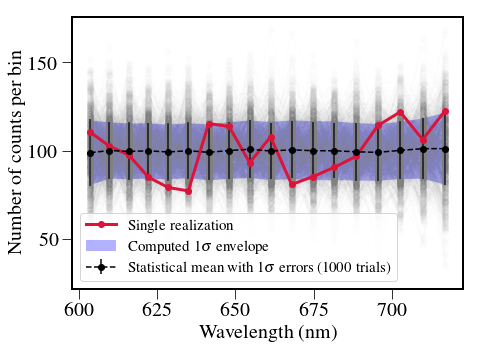

In [16]:
pixnoise = 50
vect = np.ones(N)*100
lstsq, lstsq_notsmoothed, varlstsq, Rvect = SNRcalc(
    vect, pixnoise, ntrials=1000)
lstsq = lstsq[:, :, -1]
varlstsq = varlstsq[:, :, -1]
Rvect = Rvect[:, :, -1]
lstsq_notsmoothed = lstsq_notsmoothed[:, :, -1]
np.savetxt('/Users/mrizzo/Downloads/lstsq%d.txt' % (N), lstsq)
np.savetxt('/Users/mrizzo/Downloads/varlstsq%d.txt' % (N), varlstsq)
np.savetxt('/Users/mrizzo/Downloads/Rvect%d.txt' % (N), Rvect)
np.savetxt('/Users/mrizzo/Downloads/lstsq_notsmoothed%d.txt' %
           (N), lstsq_notsmoothed)

vect1px = np.ones(N1px)*100*N/N1px
lstsq1px, lstsq_notsmoothed1px, varlstsq1px, Rvect1px = SNRcalc(vect1px, pixnoise, ntrials=1000,
                                                                psflets=psflet_subarr_1px, Niter=3)
lstsq1px = lstsq1px[:, :, -1]
varlstsq1px = varlstsq1px[:, :, -1]
Rvect1px = Rvect1px[:, :, -1]
lstsq_notsmoothed1px = lstsq_notsmoothed1px[:, :, -1]
np.savetxt('/Users/mrizzo/Downloads/lstsq%d.txt' % (N1px), lstsq1px)
np.savetxt('/Users/mrizzo/Downloads/varlstsq%d.txt' % (N1px), varlstsq1px)
np.savetxt('/Users/mrizzo/Downloads/Rvect%d.txt' % (N1px), Rvect1px)
np.savetxt('/Users/mrizzo/Downloads/lstsq_notsmoothed%d.txt' %
           (N1px), lstsq_notsmoothed1px)


lam_midpts, _ = calculateWaveList(par, method='lstsq')

plt.figure(figsize=(7, 5))
plt.plot(lam_midpts, lstsq, color='gray', alpha=0.01, marker='o')
plt.plot(lam_midpts, lstsq[:, -2], '-o',
         color='crimson', lw=3, label='Single realization')
plt.fill_between(lam_midpts, np.mean(lstsq, axis=1)-np.sqrt(varlstsq[:, -1]), np.mean(
    lstsq, axis=1)+np.sqrt(varlstsq[:, -1]), alpha=0.3, facecolor='blue', label='Computed 1$\sigma$ envelope')
plt.errorbar(lam_midpts, np.mean(lstsq, axis=1), yerr=np.std(lstsq, axis=1),
             label='Statistical mean with 1$\sigma$ errors (1000 trials)', color='k', marker='o', linestyle='dashed')
plt.legend(fontsize=15)
plt.ylabel('Number of counts per bin')
plt.xlabel(r'Wavelength (nm)')
plt.savefig('/Users/mrizzo/Downloads/Errorbars.pdf',
            dpi=150, bbox_inches='tight')

crispy - INFO - Reduced cube will have 9 wavelength bins
[ 199.3693821   199.69115909  200.30374609  199.3582525   198.73675126
  199.61364555  200.57558021  200.69764766  199.88224992]
crispy - INFO - Reduced cube will have 18 wavelength bins


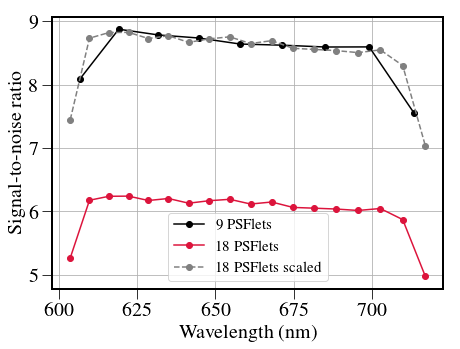

In [17]:
var9 = np.loadtxt('/Users/mrizzo/Downloads/varlstsq9.txt')
var18 = np.loadtxt('/Users/mrizzo/Downloads/varlstsq18.txt')
res9 = np.loadtxt('/Users/mrizzo/Downloads/lstsq9.txt')
res18 = np.loadtxt('/Users/mrizzo/Downloads/lstsq18.txt')
par.nchanperspec_lstsq = 1.
lam_midpts, _ = calculateWaveList(par, method='lstsq')
plt.figure(figsize=(7, 5))
print np.mean(res9, axis=1)
plt.plot(lam_midpts, np.mean(res9, axis=1) /
         np.sqrt(np.mean(var9, axis=1)), 'k', label='9 PSFlets', marker='o',)
par.nchanperspec_lstsq = 2.0
lam_midpts, _ = calculateWaveList(par, method='lstsq')
plt.plot(lam_midpts, np.mean(res18, axis=1)/np.sqrt(np.mean(var18,
                                                            axis=1)), 'crimson', marker='o', label='18 PSFlets')
plt.plot(lam_midpts, np.mean(res18, axis=1)/np.sqrt(np.mean(var18, axis=1)) *
         np.sqrt(2.), linestyle='dashed', marker='o', color='gray', label='18 PSFlets scaled')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Signal-to-noise ratio')
plt.legend()
plt.grid()
plt.savefig('/Users/mrizzo/Downloads/BinningImpactonSNR.pdf',
            dpi=150, bbox_inches='tight')

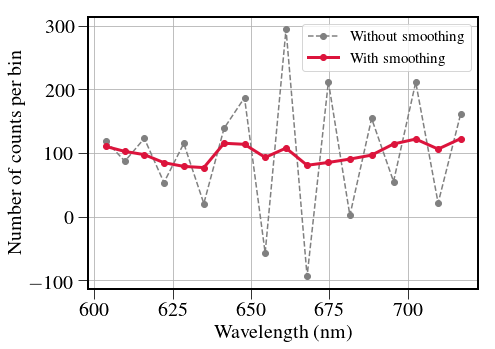

In [18]:
plt.figure(figsize=(7, 5))
plt.plot(lam_midpts,lstsq_notsmoothed[:, -2], color='gray', marker='o',
         linestyle='dashed', label='Without smoothing')
plt.plot(lam_midpts, lstsq[:, -2], '-o',
         color='crimson', lw=3, label='With smoothing')
plt.grid('on')
plt.legend()
plt.ylabel('Number of counts per bin')
plt.xlabel('Wavelength (nm)')
plt.savefig('/Users/mrizzo/Downloads/With-WithoutSmoothing.pdf',
            dpi=150, bbox_inches='tight')

# SNR and background pixels

9.78284796024 3.0397110909
18


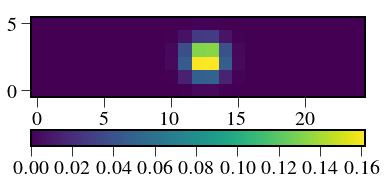

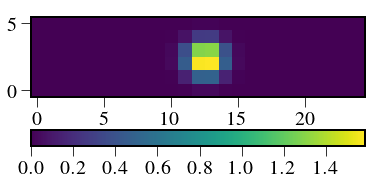

In [30]:
test = psflet_subarr[9].copy()
# test /= np.amax(test)
test /= np.sum(test)
print 1./np.sum(test**2), 1./np.sum((test[:, 12]/np.sum(test[:, 12]))**2)
plt.imshow(test)
plt.colorbar(orientation='horizontal')
plt.figure()
test /= np.sum(test**2)
plt.imshow(test)
plt.colorbar(orientation='horizontal')

print len(psflet_subarr)

The simulation to do here is the following:
1. Calculate background pixels for the central bin for many trials
2. Repeat for several sampling

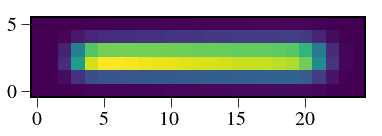

In [31]:
vect = np.ones(N)*100
tot = np.sum(psflet_subarr*vect[:, np.newaxis, np.newaxis], axis=0)
plt.imshow(tot)

In [14]:
tot /= np.sum(tot)
Npix = 1./np.sum(tot**2)
print Npix

58.1864718229


In [111]:
print Npix/19
print (Npix-9.6)/(N-2)

3.06244588542
2.85802775429


In [109]:
print 8.9/5.3
print 5.2/3.06

1.67924528302
1.69934640523


In [41]:
print N


def SNRcalcBeta(vect, pixnoise, ntrials, Niter=3, psflets=psflet_subarr):
    psflets_flat = np.reshape(psflets, (psflets.shape[0], -1))
    A = psflets_flat.T
    N = psflets.shape[0]

    lstsq_notsmoothed = np.zeros((N, ntrials, Niter+1))
    lstsq = np.zeros((N, ntrials, Niter+1))
    varlstsq = np.zeros((N, ntrials, Niter+1))
    Rvect = np.zeros((N, ntrials, Niter+1))
    beta = np.zeros((N, ntrials, Niter+1))
    for j in range(ntrials):
        pimg = np.random.poisson(
            np.sum(psflets*vect[:, np.newaxis, np.newaxis], axis=0)+pixnoise)
        img = pimg-pixnoise
        sumpix = np.sum(img)
        lstsq[:, j, 0] = np.ones(N)*sumpix/float(N)
        if j % (max(ntrials/10, 1)) == 0:
            print j, "/", ntrials
        for i in range(Niter):
            prev = lstsq[:, j, i]
            variance = np.reshape(
                np.sum(psflets*prev[:, np.newaxis, np.newaxis], axis=0)+pixnoise, -1)
            Ninv = np.diag(1./(variance+1e-10))
            Cinv = np.dot(A.T, np.dot(Ninv, A))
            C = np.linalg.inv(Cinv)
            Q = sp.linalg.sqrtm(Cinv)
            s = np.sum(Q, axis=0)
            R = Q/s[:, np.newaxis]
            x = np.reshape(img, -1)
            varlstsq[:, j, i+1] = 1./(s**2+1e-10)
            right = np.dot(A.T, np.dot(Ninv, x))
            f = np.dot(C, right)
            lstsq_notsmoothed[:, j, i+1] = f
            lstsq[:, j, i+1] = np.dot(R, f)
            Rvect[:, j, i+1] = np.dot(R, vect)
            beta[:, j, i+1] = (varlstsq[:, j, i+1]-lstsq[:, j, i+1])/pixnoise
    return lstsq, lstsq_notsmoothed, varlstsq, Rvect, beta

18


0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000


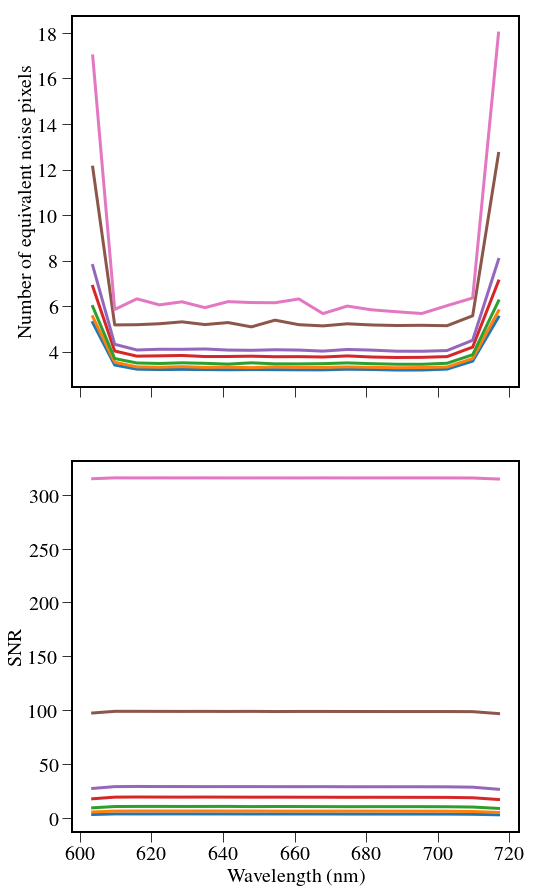

In [58]:
# Slist = [10.,50.,100,200,500,1000,10000]
# Slist = [2., 4., 8., 16., 32., 64., 128., 256.]
Slist = [50, 100., 200.,500.,1000.,10000,100000]
ntrials = 1000
fig1, (ax1,ax2) = plt.subplots(2,figsize=(8,15),sharex=True)
for pxnoise in [50]:
    betalist = []
    SNR = []
    for S in Slist:
        vect = np.ones(N)*S
        lstsq, _, varlstsq, _, beta = SNRcalcBeta(
            vect, pxnoise, ntrials=ntrials)
        ax1.plot(lam_midpts,np.mean(beta[:, :, -1], axis=1)/(lam_midpts/lam_midpts[N//2]),
                 label='Pixnoise=%d, S=%d' % (pxnoise, S),lw=3)
        ax1.set_ylabel('Number of equivalent noise pixels')
        ax2.plot(lam_midpts,np.mean(lstsq[:, :, -1]/np.sqrt(varlstsq[:, :, -1]),
                         axis=1), label='Pixnoise=%d, S=%d' % (pxnoise, S),lw=3)
#         ax2.plot(lam_midpts,np.sqrt(S))
#         ax2.errorbar(np.arange(N),np.mean(lstsq[:,:,-1],axis=1),yerr=np.std(lstsq[:,:,-1],axis=1),label='Statistical mean with 1$\sigma$ errors (1000 trials)',color='k',marker='o',linestyle='dashed')
        ax2.set_ylabel('SNR')
        ax2.set_xlabel('Wavelength (nm)')
        betalist.append(np.mean(beta[N/2, :, -1]))
        SNR.append(np.mean(lstsq[N/2, :, -1]/np.sqrt(varlstsq[N/2, :, -1])))

Text(0,0.5,u'Number of equivalent noise pixels')

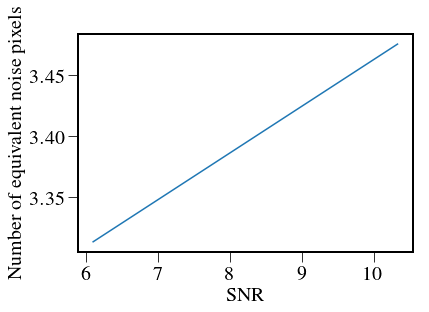

In [40]:
fig1.legend()
fig2.legend()
plt.figure()
plt.plot(SNR, betalist)
plt.xlabel('SNR')
plt.ylabel('Number of equivalent noise pixels')

## Study the background pixels as a function of background electrons per pixel

In [118]:
# Slist = [10.,50.,100,200,500,1000,10000]
Slist = [100]
# pxlist = [1.,10.,50,100,500,1000,2000,3000,4000,5000]
pxlist = [1, 5, 10., 25, 50, 75, 100, 150, 250, 500]
ntrials = 1000
# fig1,ax1 = plt.subplots()
# fig2,ax2 = plt.subplots()
for S in Slist:
    SNR = []
    SNRlast = []
    SNR_stat = []
    betalist = []
    betalast = []
    for pxnoise in pxlist:
        vect = np.ones(N)*S*19./N
        lstsq, _, varlstsq, _, beta = SNRcalcBeta(
            vect, pxnoise, ntrials=ntrials)
#         ax1.plot(np.mean(beta[:,:,-1],axis=1),label='Pixnoise=%d, S=%d'%(pxnoise,S))
#         ax1.set_ylabel('Number of equivalent noise pixels')
#         ax2.plot(np.mean(lstsq[:,:,-1]/np.sqrt(varlstsq[:,:,-1]),axis=1),label='Pixnoise=%d, S=%d'%(pxnoise,S))
#         ax2.plot(np.sqrt(S))
# #         ax2.errorbar(np.arange(N),np.mean(lstsq[:,:,-1],axis=1),yerr=np.std(lstsq[:,:,-1],axis=1),label='Statistical mean with 1$\sigma$ errors (1000 trials)',color='k',marker='o',linestyle='dashed')
#         ax2.set_ylabel('SNR')
        betalist.append(np.mean(beta[N/2, :, -1]))
        SNR.append(np.mean(lstsq[N/2, :, -1]/np.sqrt(varlstsq[N/2, :, -1])))
        SNR_stat.append(np.mean(lstsq[N/2, :, -1]/np.std(lstsq[N/2, :, -1])))
        betalast.append(np.mean(beta[-1, :, -1]))
        SNRlast.append(np.mean(lstsq[-1, :, -1]/np.sqrt(varlstsq[-1, :, -1])))
# fig1.legend()
# fig2.legend()

3.06244588542


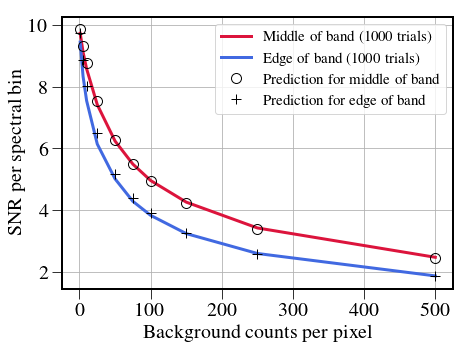

In [142]:
plt.figure(figsize=(7, 5))
plt.plot(pxlist, SNR, label='Middle of band (%d trials)' %
         ntrials, color='crimson', lw=3)
# plt.plot(pxlist,SNR_stat,label='Statistical SNR (%d trials)'%ntrials)
plt.plot(pxlist, SNRlast, label='Edge of band (%d trials)' %
         ntrials, color='royalblue', lw=3)
plt.plot(pxlist, Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*np.array(pxlist))),
         label='Prediction for middle of band', linestyle='none', marker='o', markersize=10, markerfacecolor='none', color='k')
plt.plot(pxlist, Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*1.8*np.array(pxlist))),
         label='Prediction for edge of band', linestyle='none', marker='+', markersize=10, markerfacecolor='none', color='k')
plt.xlabel('Background counts per pixel')
plt.ylabel('SNR per spectral bin')
plt.grid('on')
plt.legend()
plt.savefig('/Users/mrizzo/Downloads/BackgroundPixels.pdf',
            dpi=150, bbox_inches='tight')
print Npix/N

[9.7181679232022358, 9.1119319401944114, 8.5716994276229102, 7.4134085983822837, 6.237503603598368, 5.4938025730407603, 4.9639893465927418, 4.2663219790928686, 3.4323597735576903, 2.4850431992452053]
[ 9.85030726  9.31241487  8.74959091  7.52579578  6.2854272   5.50746103
  4.96142243  4.22816206  3.39890087  2.47595838]
10.0


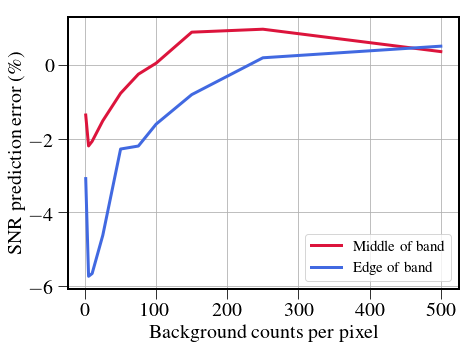

In [166]:
plt.figure(figsize=(7, 5))
plt.plot(pxlist, (SNR-Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*np.array(pxlist))))/SNR*100.,
         label='Middle of band', color='crimson', lw=3)
plt.plot(pxlist, (SNRlast-Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*1.8*np.array(pxlist))))/SNR*100.,
         label='Edge of band', color='royalblue', lw=3)
plt.grid('on')
plt.ylabel('SNR prediction error (\%)')
plt.xlabel('Background counts per pixel')
plt.legend()
print SNR
print Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*np.array(pxlist)))
print Slist[0]*19./N/(np.sqrt(Slist[0]*19./N))

Text(0,0.5,u'Equivalent $\\beta$')

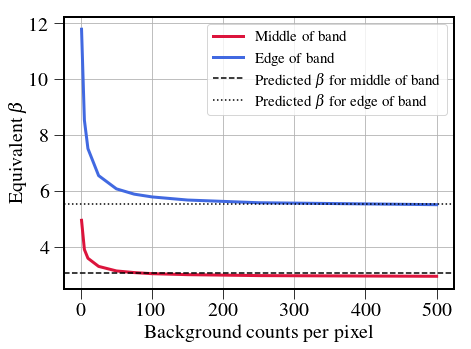

In [157]:
plt.figure(figsize=(7, 5))
# plt.plot(pxlist[1:],np.array(betalist[1:])*np.array(pxlist[1:]))
plt.plot(pxlist, np.array(betalist), color='crimson',
         label='Middle of band', lw=3)
plt.plot(pxlist, np.array(betalast),
         color='royalblue', label='Edge of band', lw=3)
plt.axhline(y=Npix/N, linestyle='--',
            label=r"Predicted $\beta$ for middle of band", color='black')
plt.axhline(y=Npix/N*1.8, linestyle=':',
            label=r"Predicted $\beta$ for edge of band", color='black')
plt.legend()
plt.grid('on', which='both')
plt.xlabel('Background counts per pixel')
plt.ylabel(r'Equivalent $\beta$')

[500.0, 250.0, 150.0, 100.0, 75.0, 50.0, 25.0, 10.0, 5.0, 1.0]
[9.7181679232022358, 9.1119319401944114, 8.5716994276229102, 7.4134085983822837, 6.237503603598368, 5.4938025730407603, 4.9639893465927418, 4.2663219790928686, 3.4323597735576903, 2.4850431992452053]
[4.943188023717223, 3.8964409196405048, 3.5817811328635392, 3.290539117721706, 3.1276250343040859, 3.0687989476741304, 3.0292280614298215, 2.994209415728462, 2.9604589269212838, 2.9354025923457581] [11.794249288731324, 8.5356133776440046, 7.5122751082333226, 6.545240890528615, 6.0708649536764829, 5.8807527783680182, 5.7815623989377407, 5.6695772399958608, 5.5727231798362205, 5.5032597250380855]
1.87478873916


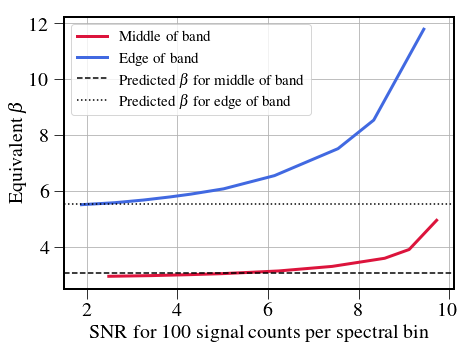

In [158]:
fig, ax = plt.subplots(figsize=(7, 5))
# plt.plot(pxlist[1:],np.array(betalist[1:])*np.array(pxlist[1:]))
ax.plot(SNR, np.array(betalist), color='crimson', label='Middle of band', lw=3)
ax.plot(SNRlast, np.array(betalast),
        color='royalblue', label='Edge of band', lw=3)
# ax2 = ax.twiny()
# ax2.plot(pxlist, np.ones(len(pxlist))) # Create a dummy plot
# ax2.cla()
invpxlist = list(np.array(pxlist)[::-1])
print invpxlist
print SNR


def tick_function(X):
    return ["%d" % z for z in X]

# ax2.set_xticks(SNR)
# ax2.set_xticklabels(tick_function(pxlist))
# ax2.set_xlabel("Number of background counts")


plt.axhline(y=Npix/N, linestyle='--',
            label=r"Predicted $\beta$ for middle of band", color='black')
plt.axhline(y=Npix/N*1.8, linestyle=':',
            label=r"Predicted $\beta$ for edge of band", color='black')
ax.legend()
ax.grid('on', which='both')
ax.set_xlabel('SNR for 100 signal counts per spectral bin')
ax.set_ylabel(r'Equivalent $\beta$')
print betalist, betalast
print betalast[-1]/betalist[-1]

## More on SNR when there is no noise background: IFS maximal extraction efficiency $\eta$

In [202]:
Slist = [x**2 for x in range(2, 17, 2)]  # [2.,4.,8.,16.,32.,64.,128.,256.]
ntrials = 1000
for pxnoise in [0]:
    SNR_nonoise = []
    for S in Slist:
        vect = np.ones(N)*S*19./N
        lstsq, _, varlstsq, _, _ = SNRcalcBeta(vect, pxnoise, ntrials=ntrials)
        SNR_nonoise.append(
            np.mean(lstsq[N/2, :, -1]/np.sqrt(varlstsq[N/2, :, -1])))

[-0.04878409 -0.01530604 -0.00599823  0.01546714 -0.02253229  0.01594308
 -0.03621935 -0.03107108] [1.9512159089708676, 3.9846939571868139, 5.9940017724324504, 8.0154671410631337, 9.977467714515436, 12.015943084948438, 13.963780653018409, 15.968928921176269]


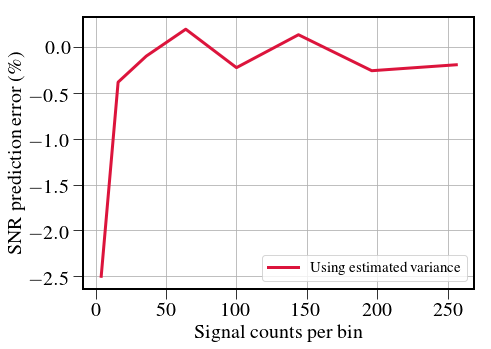

In [203]:
plt.figure(figsize=(7, 5))
plt.plot(Slist, (SNR_nonoise-np.sqrt(Slist))/SNR_nonoise*100,
         label='Using estimated variance', color='crimson', lw=3)
print (SNR_nonoise-np.sqrt(Slist)), SNR_nonoise  # /SNR*100
# plt.plot(Slist,(SNR_comp-np.sqrt(Slist))/SNR_comp*100,label='Using computed variance from trials',color='royalblue',lw=3)
# plt.plot(Slist,np.sqrt(Slist),label='Predicted SNR',color='royalblue',lw=3)

# plt.plot(pxlist,SNR_stat,label='Statistical SNR (%d trials)'%ntrials)
# plt.plot(pxlist,SNRlast,label='Edge of band (%d trials)'%ntrials,color='royalblue',lw=3)
# plt.plot(pxlist,Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*np.array(pxlist))),label='Prediction for middle of band',linestyle='none',marker='o',markersize=10,markerfacecolor='none',color='k')
# plt.plot(pxlist,Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*1.8*np.array(pxlist))),label='Prediction for edge of band',linestyle='none',marker='+',markersize=10,markerfacecolor='none',color='k')
plt.xlabel('Signal counts per bin')
plt.ylabel('SNR prediction error (\%)')
plt.grid('on')
plt.legend()

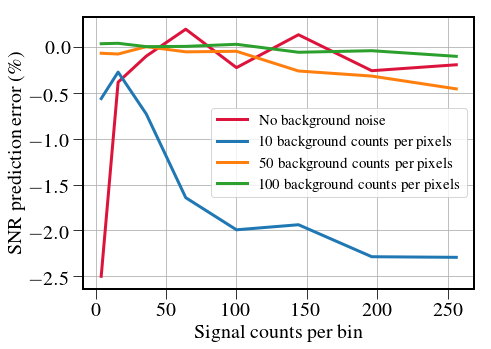

In [212]:
ntrials = 1000
plt.figure(figsize=(7, 5))
plt.plot(Slist, (SNR_nonoise-np.sqrt(Slist))/SNR_nonoise*100,
         label='No background noise', color='crimson', lw=3)

for pxnoise in [10, 50, 100]:
    SNR_noise = []
    for S in Slist:
        vect = np.ones(N)*S*19./N
        lstsq, _, varlstsq, _, _ = SNRcalcBeta(vect, pxnoise, ntrials=ntrials)
        SNR_noise.append(
            np.mean(lstsq[N/2, :, -1]/np.sqrt(varlstsq[N/2, :, -1])))

    plt.plot(Slist, (np.array(SNR_noise)-np.array(Slist)*19./N/(np.sqrt(np.array(Slist)*19./N+Npix/N*pxnoise)))/pxnoise*100.,
             label='%d background counts per pixels' % pxnoise, lw=3)
plt.xlabel('Signal counts per bin')
plt.ylabel('SNR prediction error (\%)')
plt.grid('on')
plt.legend()
plt.savefig('/Users/mrizzo/Downloads/SNRPredictionError.pdf',
            dpi=150, bbox_inches='tight')

# Now let's repeat this with the full-PSF extraction

0.0180089


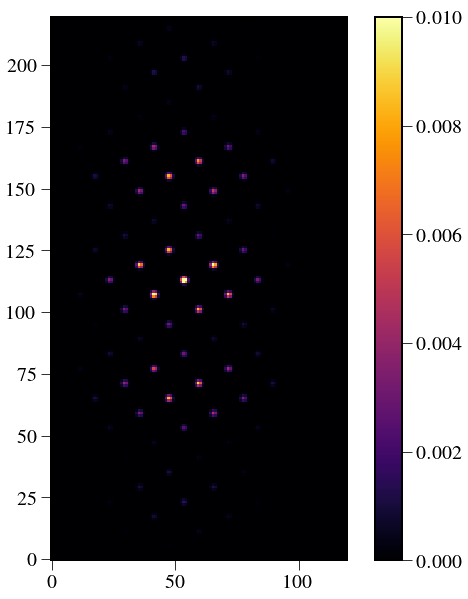

In [2]:
folder = '/Users/mrizzo/IFS/Extraction/'
PSF_polychrome = fits.open(folder+'/PSF_polychrome.fits')[1].data
PSF_polychrome_cut = PSF_polychrome[:, 400:620, 570:690]
PSF = np.zeros_like(PSF_polychrome_cut)
for i in range(PSF.shape[0]):
    PSF[i] = PSF_polychrome_cut[i]/np.sum(PSF_polychrome_cut[i])
print np.amax(PSF[0])
plt.figure(figsize=(10, 10))
plt.imshow(PSF[0], vmin=0.0, vmax=0.01, cmap=cmap)
plt.colorbar()

(-0.5, 34.5, -0.5, 64.5)

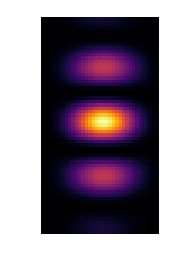

In [7]:
offaxis_psf_filename = '/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits'
offaxis = fits.open(offaxis_psf_filename)[0].data
plt.imshow(offaxis[0, 95:160, 180:215], cmap=cmap)
plt.axis('off')

1.0
114.516143585


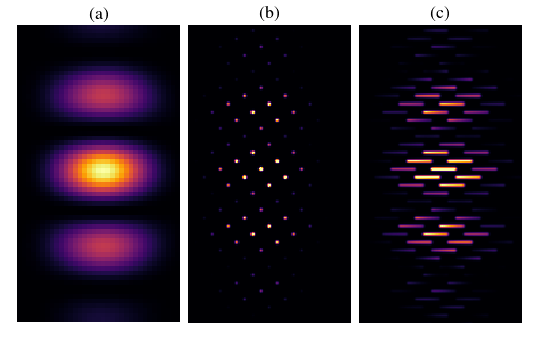

In [9]:
N = PSF.shape[0]
vect = np.ones(N)*100*19./N
tot = np.sum(PSF*vect[:, np.newaxis, np.newaxis], axis=0)
tot /= np.sum(tot)
totpower = np.sum(tot)
print totpower
print 1./np.sum(tot**2)/N
Npix = 1./np.sum(tot**2)
# plt.figure(figsize=(7,15))
# mask = tot<np.amax(tot)/4
# tot[mask]=0
# print np.sum(tot)

# tot/=np.sum(tot)
# print 1./np.sum(tot**2)/N
# plt.imshow(tot,cmap=cmap)
# plt.colorbar()
plt.figure(figsize=(7, 7))
plt.subplot(131)
plt.imshow(offaxis[0, 96:160, 180:215], cmap=cmap)
plt.title('(a)')
plt.axis('off')
import matplotlib.ticker as ticker
plt.gca().xaxis.set_major_locator(ticker.NullLocator())
plt.gca().yaxis.set_major_locator(ticker.NullLocator())

plt.subplot(132)
plt.imshow(PSF[0], vmin=0.0, vmax=0.005, cmap=cmap)
plt.title('(b)')
plt.axis('off')
plt.gca().xaxis.set_major_locator(ticker.NullLocator())
plt.gca().yaxis.set_major_locator(ticker.NullLocator())
plt.subplot(133)
plt.imshow(tot/100, vmax=0.00001, cmap=cmap)
plt.title('(c)')
plt.axis('off')
# plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_axis_off()
plt.margins(0, 0)
import matplotlib.ticker as ticker
# plt.gca().xaxis.set_major_locator(NullLocator())
# plt.gca().yaxis.set_major_locator(NullLocator())
plt.gca().xaxis.set_major_locator(ticker.NullLocator())
plt.gca().yaxis.set_major_locator(ticker.NullLocator())

plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                    hspace=0, wspace=0.05)
# plt.subplots_adjust(left=0.0,bottom=0.0,top=1.0,wspace=0.05,hspace=0.0)
plt.savefig('/Users/mrizzo/Downloads/FullPSF.pdf',
            dpi=150, bbox_inches='tight', pad_inches=0)

In [255]:
# Slist = [10.,50.,100,200,500,1000,10000]
Slist = [1000]
# pxlist = [1.,10.,50,100,500,1000,2000,3000,4000,5000]
pxlist = [2**p for p in range(5, 10)]
ntrials = 1000
# fig1,ax1 = plt.subplots()
# fig2,ax2 = plt.subplots()
for S in Slist:
    SNR = []
    SNRlast = []
    SNR_stat = []
    betalist = []
    betalast = []
    for pxnoise in pxlist:
        vect = np.ones(N)*S*19./N
        print pxnoise
        lstsq, _, varlstsq, _, beta = SNRcalcBeta(
            vect, pxnoise, ntrials=ntrials, psflets=PSF, Niter=3)
#         ax1.plot(np.mean(beta[:,:,-1],axis=1),label='Pixnoise=%d, S=%d'%(pxnoise,S))
#         ax1.set_ylabel('Number of equivalent noise pixels')
#         ax2.plot(np.mean(lstsq[:,:,-1]/np.sqrt(varlstsq[:,:,-1]),axis=1),label='Pixnoise=%d, S=%d'%(pxnoise,S))
#         ax2.plot(np.sqrt(S))
# #         ax2.errorbar(np.arange(N),np.mean(lstsq[:,:,-1],axis=1),yerr=np.std(lstsq[:,:,-1],axis=1),label='Statistical mean with 1$\sigma$ errors (1000 trials)',color='k',marker='o',linestyle='dashed')
#         ax2.set_ylabel('SNR')
        betalist.append(np.mean(beta[N/2, :, -1]))
        SNR.append(np.mean(lstsq[N/2, :, -1]/np.sqrt(varlstsq[N/2, :, -1])))
        SNR_stat.append(np.mean(lstsq[N/2, :, -1]/np.std(lstsq[N/2, :, -1])))
        betalast.append(np.mean(beta[-1, :, -1]))
        SNRlast.append(np.mean(lstsq[-1, :, -1]/np.sqrt(varlstsq[-1, :, -1])))
# fig1.legend()
# fig2.legend()

32
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
64
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
128
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
256
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
512
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000


In [256]:
print SNR, betalist, SNRlast, betalast

[14.059235992818845, 10.789131357991744, 7.9753190211721439, 5.8527687170406235, 4.1408439419855769] [126.90683778611185, 119.38281923093977, 114.9576659867636, 112.47022784109431, 111.17700154249223] [10.640071654771035, 7.9504471843887643, 5.7907635476834125, 4.1247067005938591, 2.8964487929171554] [243.71891452700737, 231.21228819266338, 224.18732000096432, 220.38343973802216, 218.41562107312296]


In [254]:
print [2**p for p in range(5, 10)]
print [x**2 for x in range(5, 10)]

[32, 64, 128, 256, 512]


58.1864718229


114.516143585


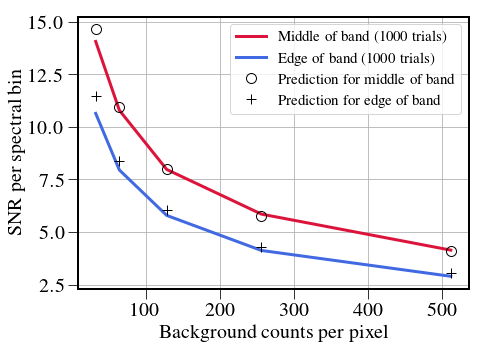

In [265]:
plt.figure(figsize=(7, 5))
plt.plot(pxlist, SNR, label='Middle of band (%d trials)' %
         ntrials, color='crimson', lw=3)
# plt.plot(pxlist,SNR_stat,label='Statistical SNR (%d trials)'%ntrials)
plt.plot(pxlist, SNRlast, label='Edge of band (%d trials)' %
         ntrials, color='royalblue', lw=3)
plt.plot(pxlist, Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*np.array(pxlist))),
         label='Prediction for middle of band', linestyle='none', marker='o', markersize=10, markerfacecolor='none', color='k')
plt.plot(pxlist, Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*1.8*np.array(pxlist))),
         label='Prediction for edge of band', linestyle='none', marker='+', markersize=10, markerfacecolor='none', color='k')
plt.xlabel('Background counts per pixel')
plt.ylabel('SNR per spectral bin')
plt.grid('on')
plt.legend()
plt.savefig('/Users/mrizzo/Downloads/BackgroundPixels_FullPSF.pdf',
            dpi=150, bbox_inches='tight')
print Npix/N

38.3518341728


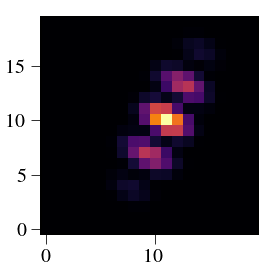

In [66]:
planet_cube = fits.getdata(folder+'planet_cube_optext.fits')
subimg = planet_cube[N/2, 40:60, 50:70]
# subimg = planet_cube[N/2]
plt.imshow(subimg, cmap=cmap)
tot = subimg/np.nansum(subimg)
print 1./np.nansum(tot**2)

# Comparison between full forward model and regular matched filter

### Polychrome in full frame

0.0180023


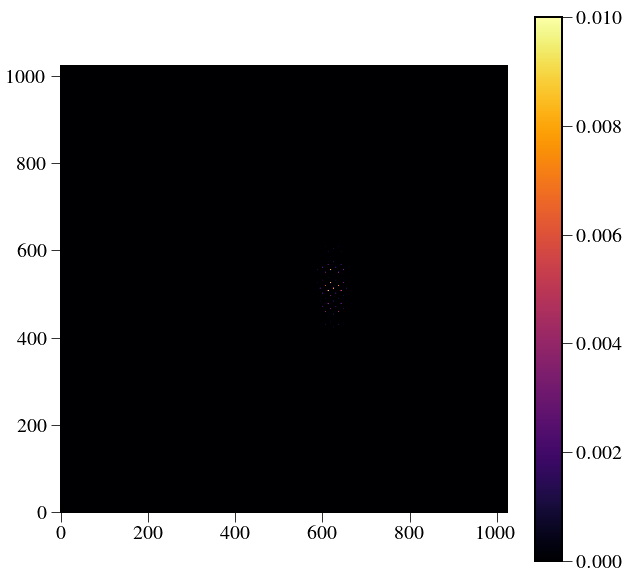

In [2]:
folder = '/Users/mrizzo/IFS/Extraction/'
PSF_polychrome = fits.open(folder+'/PSF_polychrome.fits')[1].data
# PSF_polychrome_cut = PSF_polychrome[:,400:620,570:690]
PSF_polychrome_cut = PSF_polychrome
PSF = np.zeros_like(PSF_polychrome_cut)
for i in range(PSF.shape[0]):
    PSF[i] = PSF_polychrome_cut[i]/np.sum(PSF_polychrome_cut[i])
print np.amax(PSF[0])
plt.figure(figsize=(10, 10))
plt.imshow(PSF[0], vmin=0.0, vmax=0.01, cmap=cmap)
plt.colorbar()
N = PSF.shape[0]

### Construct the matched filter

In [6]:
# IWA=3
# OWA=9
# mask,scratch = bowtie(PSF[0],ydim//2-1,xdim//2,openingAngle=65,
#         clocking=-par.philens*180./np.pi,
#         IWApix=IWA*lamc/par.lenslet_wav/par.lenslet_sampling,
#         OWApix=OWA*lamc/par.lenslet_wav/par.lenslet_sampling,
#         export=None,twomasks=False)

# construct_mflib(par,planet_cube=folder+'planet_cube.fits',
#                 threshold=0.2,
#                 lamc=lamc,
#                 BW=BW,
#                 outdir=folder,
#                 mask=mask,
#                 trim=30,
#                 outname = 'mflib.fits.gz',
#                 order=3)
mflib = folder+'mflib.fits.gz'

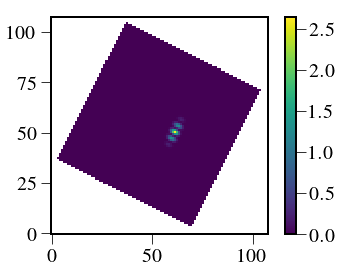

In [3]:
planet_cube = fits.getdata(folder+'planet_cube_optext.fits')
mf = np.zeros_like(planet_cube)
psf = np.zeros_like(planet_cube)
for i in range(planet_cube.shape[0]):
    psf[i] = planet_cube[i]/np.nansum(planet_cube[i])
    mf[i] = psf[i]/np.nansum(psf[i]**2)
plt.imshow(mf[N/2])
plt.colorbar()

### Write function that computes SNR from both methods

In [7]:
from crispy.IFS import reduceIFSMap
from crispy.tools.postprocessing import construct_mflib, convolved_mf


def SNRcompare(vect, pixnoise, ntrials, psflets=PSF, niter=3):
    N = psflets.shape[0]

    lstsq = np.zeros((N, ntrials, niter+1))
    varlstsq = np.zeros((N, ntrials, niter+1))
    lstsqlenslet = np.zeros((N, ntrials))
    varlstsqlenslet = np.zeros((N, ntrials))
    mfiltered = np.zeros((N, ntrials))
    mfcov = np.zeros((N, ntrials))
    Rvect = np.zeros((N, ntrials, niter+1))
    for j in range(ntrials):
        avgimg = np.sum(
            psflets*vect[:, np.newaxis, np.newaxis], axis=0)+pixnoise
        avgimg[avgimg < 0] = 0.0
        pimg = np.random.poisson(avgimg)
        img = pimg-pixnoise
        subim = img[400:620, 570:690]
        sumpix = np.sum(subim)
        subpsflets = psflets[:, 400:620, 570:690]
        lstsq[:, j, 0] = np.ones(N)*sumpix/float(N)
        if j % (max(ntrials/10, 1)) == 0:
            print j, "/", ntrials
        for i in range(niter):
            prev = lstsq[:, j, i]
            variance = np.reshape(
                np.sum(subpsflets*prev[:, np.newaxis, np.newaxis], axis=0)+pixnoise, -1)
            Ninv = np.diag(1./(variance+1e-10))
            psflets_flat = np.reshape(subpsflets, (subpsflets.shape[0], -1))
            A = psflets_flat.T
            Cinv = np.dot(A.T, np.dot(Ninv, A))
            C = np.linalg.inv(Cinv)
            Q = sp.linalg.sqrtm(Cinv)
            s = np.sum(Q, axis=0)
            R = Q/s[:, np.newaxis]
            x = np.reshape(subim, -1)
            varlstsq[:, j, i+1] = 1./(s**2+1e-10)
            right = np.dot(A.T, np.dot(Ninv, x))
            f = np.dot(C, right)
            lstsq[:, j, i+1] = np.dot(R, f)
            Rvect[:, j, i+1] = np.dot(R, vect)

        # Now extract into cube
        cubeout = reduceIFSMap(par, img.astype(float), method='lstsq_conv', smoothbad=False,
                               fitbkgnd=False, niter=niter, pixnoise=pixnoise, normpsflets=True)
        # Apply matched filter to data and variance
#         convolved = convolved_mf(cubeout.data,mflib)
#         convvar = convolved_mf(1./(cubeout.ivar+1e-10),mflib)
        # Find peak
#         yp,xp = np.unravel_index(np.nanargmax(convolved[N//2]), convolved[N//2].shape)
#         mfiltered[:,j] = convolved[:,yp,xp]
#         mfcov[:,j] = convvar[:,yp,xp]
        for k in range(N):
            mfiltered[k, j] = np.nansum(cubeout.data[k]*mf[k])
            mfcov[k, j] = np.nansum((1./cubeout.ivar[k])*mf[k]**2)
#             guess = np.nansum(cubeout.data[k]*mf[k])
#             #variance = np.reshape(1./(cubeout.ivar[k]+1e-10),-1)
#             Ninv = np.diag(np.reshape(cubeout.ivar[k],-1))
#             psfs_flat = np.reshape(psf[k], -1)
#             A = psfs_flat.T
#             Cinv = np.dot(A.T,np.dot(Ninv,A))
#             Cinv =
#             C = np.linalg.inv(Cinv)
#             x = np.reshape(cubeout.data[k],-1)
#             right = np.dot(A.T,np.dot(Ninv,x))
#             lstsqlenslet[k,j] = np.dot(C,right)
#             varlstsqlenslet[k,j] = C

    # ,lstsqlenslet,varlstsqlenslet
    return lstsq[:, :, -1], varlstsq[:, :, -1], mfiltered, mfcov, cubeout

In [20]:
# Ninv = np.diag(np.reshape(cubeout.ivar[N/2],-1))
# psfs_flat = np.reshape(psf[N/2], -1)
# A = psfs_flat.T
# Cinv = np.dot(A.T,np.dot(Ninv,A))
# Cinv= np.nansum(psfs_flat**2*Ninv)
# print np.sqrt(1./Cinv)
print np.nansum(mf[N/2]**2), np.nansum(mf[N/2])
print mf[N/2, 51, 62], mf[N/2, 51, 62]**2
print np.sqrt(np.nansum(cubeout.data[N/2]*mf[N/2])+114*100)
print

38.3518 38.3518
0.565407 0.319685050918
109.476746906



In [121]:
print cubeout.data[N/2, 50, 61], np.sqrt(1./cubeout.ivar[N/2, 50, 61])

53.6751473016 74.6397125127


In [18]:
N = PSF.shape[0]
S = 500
pixnoise = 1000
vect = np.ones(N)*S*19./N
ntrials = 1
lstsq, varlstsq, mfiltered, mfcov, cubeout = SNRcompare(
    vect, pixnoise, ntrials)

0 / 1
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180208-165351_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180208-165351_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 22.105994s


-1582.85751479


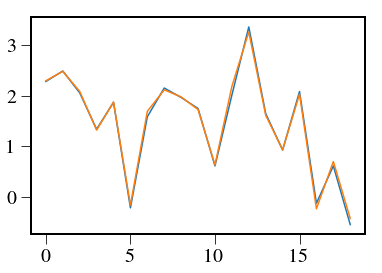

In [19]:
plt.plot(mfiltered/np.sqrt(mfcov))
plt.plot(lstsq/np.sqrt(varlstsq))
print np.nansum(cubeout.data[N/2])

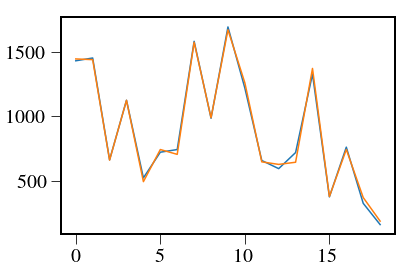

In [16]:
plt.plot(lstsq)
plt.plot(mfiltered)

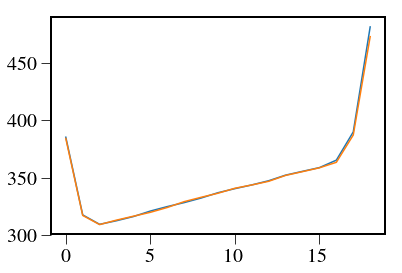

In [17]:
plt.plot(np.sqrt(mfcov))
plt.plot(np.sqrt(varlstsq))

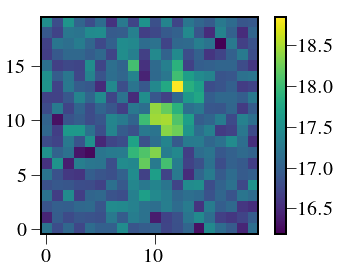

In [12]:
plt.imshow(1./np.sqrt(cubeout.ivar[N/2, 40:60, 50:70]))
plt.colorbar()

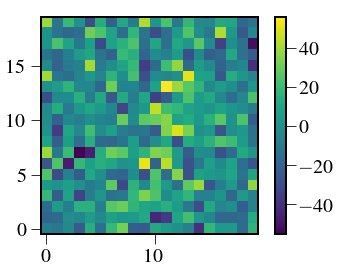

In [13]:
plt.imshow(cubeout.data[N/2, 40:60, 50:70])
plt.colorbar()

In [13]:
print lstsq, mfiltered

[[ 1061.31082252]
 [  994.51910918]
 [ 1067.93241136]
 [  943.40005562]
 [ 1023.78083903]
 [  871.57754423]
 [ 1007.34183633]
 [ 1022.40889456]
 [ 1015.63451369]
 [ 1047.93379362]
 [  883.44915616]
 [ 1076.92231621]
 [ 1004.4325102 ]
 [  992.7912267 ]
 [  863.55120109]
 [ 1131.7923657 ]
 [  873.40494278]
 [  992.60197439]
 [  912.4299098 ]] [[ 1067.61078115]
 [  979.30638396]
 [ 1071.10937563]
 [  929.73694601]
 [ 1031.18331398]
 [  867.98491063]
 [ 1004.43710252]
 [ 1015.80880313]
 [ 1008.57727183]
 [ 1058.5582396 ]
 [  870.79418333]
 [ 1072.97664416]
 [ 1018.21021301]
 [ 1015.53393698]
 [  863.72700666]
 [ 1105.59609786]
 [  903.43050243]
 [ 1006.46072792]
 [  964.38377064]]


In [50]:
N = PSF.shape[0]
S = 1000
pixnoise = 100
vect = np.ones(N)*S*19./N
ntrials = 50
lstsq, varlstsq, mfiltered, mfcov, cubeout = SNRcompare(
    vect, pixnoise, ntrials)

0 / 50
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180207-150326_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180207-150326_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 23.342800s
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180207-150356_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180207-150356_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 23.030375s
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180207-150426_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180207-150426_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 23.071605s
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180207-150455_red_lstsq_conv_resid.fits
crispy - INFO -

crispy - INFO - Writing data to ..//SimResults/20180207-151752_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 23.313976s
30 / 50
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180207-151822_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180207-151822_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 23.442288s
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180207-151852_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180207-151852_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 23.477376s
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180207-151922_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180207-151922_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 23.319423s
crispy - INFO - Reduced cube wi

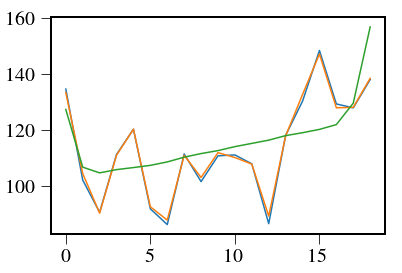

In [57]:
plt.plot(np.std(lstsq, axis=1))
plt.plot(np.std(mfiltered, axis=1))
plt.plot(np.sqrt(varlstsq[:, -1]))

In [65]:
np.mean(lstsq-mfiltered, axis=1)

array([ -6.74855616,   1.93142258,   5.03869093,   6.41954798,
         4.33683876,  -1.61534121,  -0.81748592,   5.17931096,
         1.38307764,   3.5391345 ,   0.54107266,   1.9549089 ,
        -2.38907262,  -0.1499417 ,   1.27518251,  -1.20862136,
        -0.77566602, -37.47518884, -41.80053688])

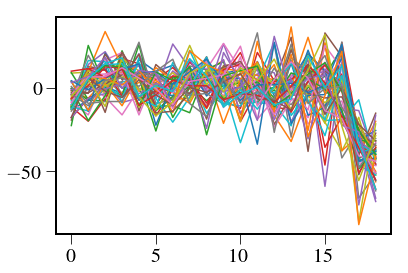

In [60]:
plt.plot(lstsq-mfiltered)

In [64]:
np.sqrt(np.nansum((1./(cubeout.ivar[N/2]))*mf[N/2]))

461.01998777490553

In [32]:
from crispy.IFS import reduceIFSMap
from crispy.tools.postprocessing import construct_mflib, convolved_mf
N = PSF.shape[0]
S = 10000
pixnoise = 100
vect = np.ones(N)*S*19./N
pimg = np.random.poisson(
    np.sum(PSF*vect[:, np.newaxis, np.newaxis], axis=0)+pixnoise)
img = (pimg-pixnoise).astype(float)
cubeout = reduceIFSMap(par, img, method='lstsq_conv',
                       smoothbad=False, fitbkgnd=False, niter=3, pixnoise=pixnoise)

crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180207-130240_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180207-130240_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 21.131454s


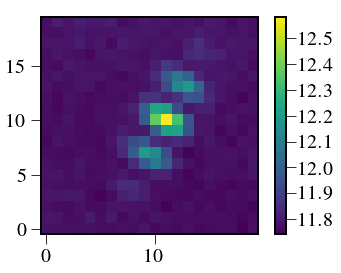

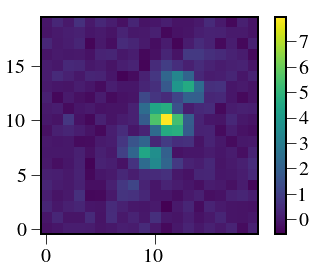

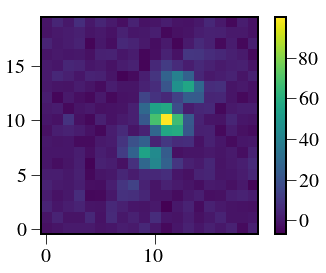

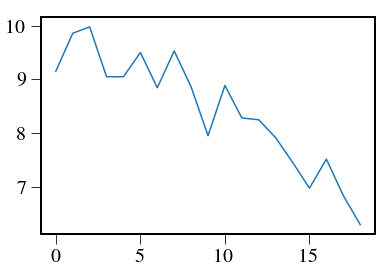

In [38]:
plt.imshow(1./np.sqrt(cubeout.ivar[N/2, 40:60, 50:70]))
plt.colorbar()  # print(np.sqrt(1./cubeout.ivar[N/2,40:60,50:70]))
# print(cubeout.data[N/2,40:60,50:70])
plt.figure()
plt.imshow(cubeout.data[N/2, 40:60, 50:70] *
           np.sqrt(cubeout.ivar[N/2, 40:60, 50:70]))
plt.colorbar()
plt.figure()
plt.imshow(cubeout.data[N/2, 40:60, 50:70])
plt.colorbar()
plt.figure()
plt.plot(cubeout.data[:, 50, 61]*np.sqrt(cubeout.ivar[:, 50, 61]))